# Tree Learning – implementation and application of decision trees

## Introduction

This notebook gives you the opportunity to implement some key components of decision tree learning and run your algorithm on a benchmark dataset. So restrictions will be made to simplify the problem. The notebook concludes by asking you to run the decision tree learning (and tree-based method of "Random Forests") from scikit-learn for comparison.

Make sure you have the Titanic dataset ("```titanic.csv```") in the directory from where you are running the notebook before you start.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
ds = pd.read_csv('titanic.csv')
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Data Preprocessing 

To simplify things we will focus on the supplied dataset and start by doing some preprocessing, including feature selection, turning categorical data to numeric, and some other stuff. Spend about 10 minutes and go through this if you have any doubts. We start by inspecting the dataset. 

In [3]:
ds.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [11]:
cols_to_drop = [
    'PassengerId',
    'Name',
    'Ticket',
    'Cabin',
    'Embarked',
]

df = ds.drop(cols_to_drop, axis=1)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,male,22.0,1,0,7.2500
1,1,1,female,38.0,1,0,71.2833
2,1,3,female,26.0,0,0,7.9250
3,1,1,female,35.0,1,0,53.1000
4,0,3,male,35.0,0,0,8.0500


Another simplification will be to treat all attributes as numeric. So we need to convert any that are not.

In [12]:
def convert_sex_to_num(s):
    if s=='male':
        return 0
    elif s=='female':
        return 1
    else:
        return s

df.Sex = df.Sex.map(convert_sex_to_num)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,0,22.0,1,0,7.2500
1,1,1,1,38.0,1,0,71.2833
2,1,3,1,26.0,0,0,7.9250
3,1,1,1,35.0,1,0,53.1000
4,0,3,0,35.0,0,0,8.0500


Let's overview the preprocessed dataset now with some standard commands.

In [13]:
data = df.dropna()
data.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
count,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000
mean,0.406162,2.236695,0.365546,29.699118,0.512605,0.431373,34.694514
std,0.491460,0.838250,0.481921,14.526497,0.929783,0.853289,52.918930
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,20.125000,0.000000,0.000000,8.050000
50%,0.000000,2.000000,0.000000,28.000000,0.000000,0.000000,15.741700
75%,1.000000,3.000000,1.000000,38.000000,1.000000,1.000000,33.375000
max,1.000000,3.000000,1.000000,80.000000,5.000000,6.000000,512.329200


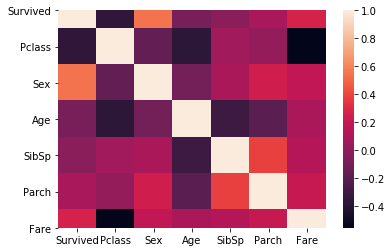

In [14]:
plt.figure()
sns.heatmap(data.corr())

In [4]:
input_cols = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']
out_cols = ['Survived']

X = data[input_cols]
y = data[out_cols]

#X.head()
print (X.shape, y.shape)

NameError: name 'data' is not defined

# data = data.reset_index(drop=True)


## Functions for your Decision Tree learning algorithm

Now is your chance to go ahead and implement some of the functionality needed for the decision tree learner. Remember that the _class_ variable for which we need to learn a tree is ```Survived```.

In [31]:
def divide_data(x_data, fkey, fval):
    x_right = pd.DataFrame([], columns=x_data.columns)
    x_left = pd.DataFrame([], columns=x_data.columns)
    
    
    for ix in range(x_data.shape[0]):
        # Retrieve the current value for the fkey column
        try:
            val = x_data[fkey].loc[ix]
        except:
            print (x_data[fkey])
            val = x_data[fkey].loc[ix]
        # print val
        
        # Check where the row needs to go
        if val > fval:
            # pass the row to right
            x_right = x_right.append(x_data.loc[ix])
        else:
            # pass the row to left
            x_left = x_left.append(x_data.loc[ix])
    
    # return the divided datasets
    return x_left, x_right


def entropy(col):
    p = []
    p.append(col.mean())
    p.append(1-p[0])
    
    ent = 0.0
    for px in p:
        ent += (-1.0 * px * np.log2(px))
    return ent

def information_gain(xdata, fkey, fval):
    left, right = divide_data(xdata, fkey, fval)
    
    if left.shape[0] == 0 or right.shape[0] == 0:
        return -10000
    
    return entropy(xdata.Survived) - (entropy(left.Survived)*float(left.shape[0]/float(left.shape[0]+right.shape[0])) + entropy(right.Survived)*float(right.shape[0]/float(left.shape[0]+right.shape[0])))

In [33]:
#Here X is your data without the Survived column. Run it after you have filled in the missing code above.
for fx in X.columns:
    print (fx) 
    print (information_gain(data, fx, data[fx].mean()))

Pclass
0.0841581440715109
Sex
0.21601606075154267
Age
2.6666107433293007e-08
SibSp
0.006904127996153919
Parch
0.019278172321014697
Fare
0.053719589963652226


In [35]:
class DecisionTree:
    def __init__(self, depth=0, max_depth=5):
        self.left = None
        self.right = None
        self.fkey = None
        self.fval = None
        self.max_depth = max_depth
        self.depth = depth
        self.target = None
    
    def train(self, X_train):
        print (self.depth, '-'*10)
        # Get the best possible feature and division value
        features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']
        gains = []
        for fx in features:
            gains.append(information_gain(X_train, fx, X_train[fx].mean()))
        
        # store the best feature (using min information gain)
        self.fkey = features[np.argmax(gains)]
        self.fval = X_train[self.fkey].mean()
        
        # divide the dataset
        data_left, data_right = divide_data(X_train, self.fkey, self.fval)
        data_left = data_left.reset_index(drop=True)
        data_right = data_right.reset_index(drop=True)
        
        # Check the shapes
        if data_left.shape[0] == 0 or data_right.shape[0] == 0:
            if X_train.Survived.mean() >= 0.5:
                self.target = 'Survived'
            else:
                self.target = 'Dead'
            return
        
        if self.depth >= self.max_depth:
            if X_train.Survived.mean() >= 0.5:
                self.target = 'Survived'
            else:
                self.target = 'Dead'
            return
        
        # branch to right
        self.right = DecisionTree(depth=self.depth+1, max_depth=self.max_depth)
        self.right.train(data_right)
        # branch to left
        self.left = DecisionTree(depth=self.depth+1, max_depth=self.max_depth)
        self.left.train(data_left)
        
        if X_train.Survived.mean() >= 0.5:
            self.target = 'Survived'
        else:
            self.target = 'Dead'
        
        return
    
    def predict(self, test):
        if test[self.fkey] > self.fval:
            # go right
            if self.right is None:
                return self.target
            return self.right.predict(test)
        else:
            # go left
            if self.left is None:
                return self.target
            return self.left.predict(test)

## Divide your data: separate Training and Test sets

In [73]:
split = int(0.8 * data.shape[0])

training_data = data[:split]
testing_data = data[split:]

## Train your own decision tree

In [74]:
dt = DecisionTree()
dt.train(training_data)

0 ----------
1 ----------
2 ----------
3 ----------
4 ----------
5 ----------


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log2
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in double_scalars


5 ----------
4 ----------
5 ----------
5 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
2 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
1 ----------
2 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
2 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------
3 ----------
4 ----------
5 ----------
5 ----------
4 ----------
5 ----------
5 ----------


In [39]:
print (dt.fkey, dt.fval)
print (dt.right.fkey, dt.right.fval)
print (dt.left.fkey, dt.left.fval)

print (dt.right.right.fkey, dt.right.right.fval)
print (dt.right.left.fkey, dt.right.left.fval)


print (dt.left.right.fkey, dt.left.right.fval)
print (dt.left.left.fkey, dt.left.left.fval)


Sex 0.36777583187390545
Pclass 2.080952380952381
Fare 28.257881994459833
SibSp 0.9036144578313253
Age 30.830708661417322
SibSp 1.0721649484536082
Fare 12.418069696969695


Make predictions for the first 10 and see if they are correct.

In [82]:

for ix in testing_data.index[:10]:
    print
    print (dt.predict(testing_data.loc[ix]))
testing_data.values[1]

Dead
Survived
Dead
Dead
Dead
Survived
Dead
Survived
Dead
Dead


array([ 1.,  2.,  1.,  6.,  0.,  1., 33.])

In [84]:
testing_data.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
571,0,3,0,33.0,0,0,7.7750
572,1,2,1,6.0,0,1,33.0000
573,0,3,0,17.0,1,0,7.0542
574,0,2,0,34.0,0,0,13.0000
575,0,2,0,50.0,0,0,13.0000
576,1,1,0,27.0,1,0,53.1000
577,0,3,0,20.0,0,0,8.6625
578,1,2,1,30.0,3,0,21.0000
579,0,2,0,25.0,1,0,26.0000
580,0,3,1,25.0,1,0,7.9250


Now check for the entire test set how many you get correct: aim to get at least 75 percent accuracy !

In [83]:
correct = 0
for ix in testing_data.index:
    a = dt.predict(testing_data.loc[ix])
    if testing_data.loc[ix].Survived == 0 :
        if a == 'Dead' : 
            correct += 1
    if testing_data.loc[ix].Survived == 1 :
        if a == 'Survived' : 
            correct += 1
print (correct)
print (testing_data.shape[0])
print (float(correct/testing_data.shape[0]))

120
143
0.8391608391608392


## Now use SKLEARN: Decision tree and Random Forests

In [75]:
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [76]:
DT = DecisionTreeClassifier()
DT.fit(X[:split], y[:split])

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [78]:
DT.score(X[split:], y[split:])

0.7902097902097902

In [79]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X[:split], y[:split])

rf.score(X[split:], y[split:])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.8461538461538461